# 1 Setup

In [2]:
from scripts import helpers, risk_factors, portfolio, pricing, var_models, ex_post_risk

In [3]:
helpers.log_version_info()

Developed in Python v. 3.7.0, running using Python 3.7.0.

           Version Developed in Version Running
pandas                    1.0.1           1.0.1
numpy                    1.18.0          1.18.0
scipy                     1.4.1           1.4.1
matplotlib                3.1.2           3.1.2
sklearn                  0.22.1          0.22.1
pylatex                   1.4.1           1.4.1
yfinance                 0.1.62          0.1.62
seaborn                  0.10.0          0.10.0
QuantLib                   1.22            1.22


In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [5]:
report = helpers.Report(name='report')

# 2 Configuration

In [6]:
report.chapter('Configuration')

In [7]:
config, amer_opt_params = helpers.read_models_config('inputs/config.csv', report)

risk_factors_path   None
ptf_spec_path       inputs/portfolio.csv
load_from_csv       False
start               2019-01-01
end                 2021-06-30
confidence          0.95
n_mc_scenarios      2000
hs_period           500
VaR_horizon         10
n_bootstrap         10000
lmbda               0.94
rf_estim_method     ledoit_wolf
vol_period          500
corr_period         250
lsmc_simulations    50
lsmc_granularity    50
amer_opt_p_method   crr
crr_tree_height     50
option_pricing      quantlib
bt_horizon          W
estimation_window   52
riskfree_rate       0.0
jarque_bera_alpha   0.01
cov_estim_method    ledoit_wolf
nan_threshold       0.1


# 3 Exposures

In [8]:
report.chapter('Risk Factors')

## 3.1 Position Specifications and Risk Factor Returns


Position Configurations:
     type  securities_contracts direction price_ticker
0  Equity                    10      Long         AAPL
1  Equity                    10      Long         AMZN
2  Equity                    10      Long           FB
3  Equity                    10      Long         GOOG

Risk Factors:
[('FB', 'price'), ('AAPL', 'price'), ('GOOG', 'price'), ('AMZN', 'price')]
[*********************100%***********************]  4 of 4 completed

Risk Factors Prices:
                    FB        AAPL         GOOG         AMZN
Date                                                        
2021-06-29  351.890015  136.330002  2520.370117  3448.139893
2021-06-28  355.640015  134.779999  2536.389893  3443.889893
2021-06-25  341.369995  133.110001  2539.899902  3401.459961
2021-06-24  343.179993  133.410004  2545.639893  3449.080078
2021-06-23  340.589996  133.699997  2529.229980  3503.820068


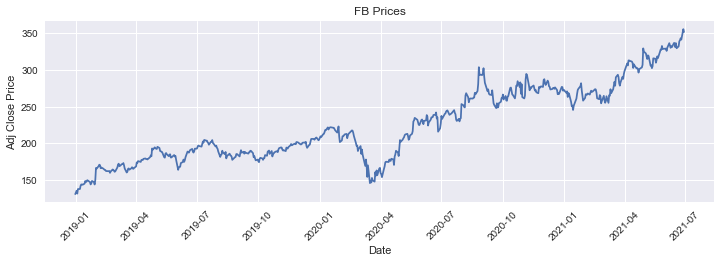

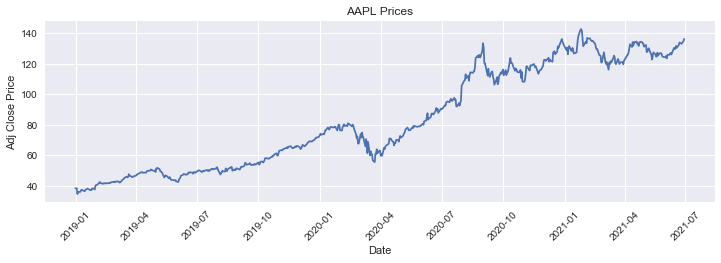

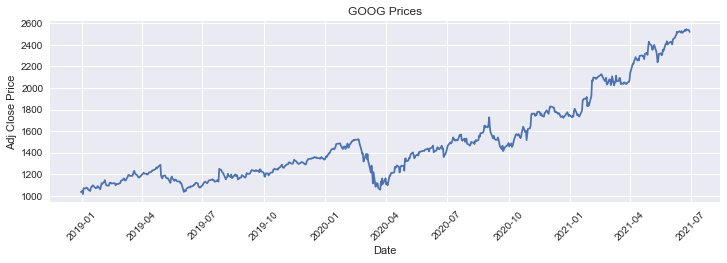

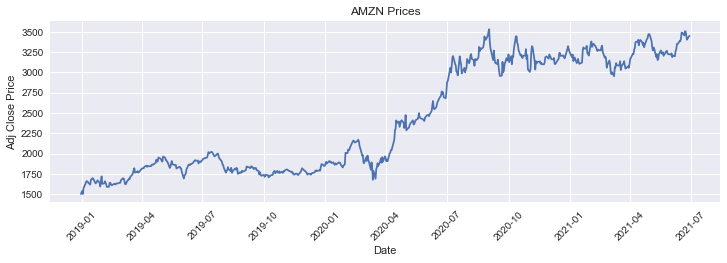

Risk Factor Log-Returns:
                  FB      AAPL      GOOG      AMZN
Date                                              
2021-06-29 -0.010600  0.011435 -0.006336  0.001233
2021-06-28  0.040952  0.012468 -0.001383  0.012397
2021-06-25 -0.005288 -0.002251 -0.002257 -0.013903
2021-06-24  0.007576 -0.002171  0.006467 -0.015746
2021-06-23  0.004591 -0.002092 -0.004245 -0.000462


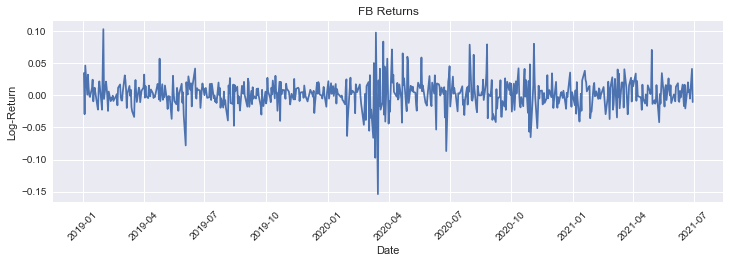

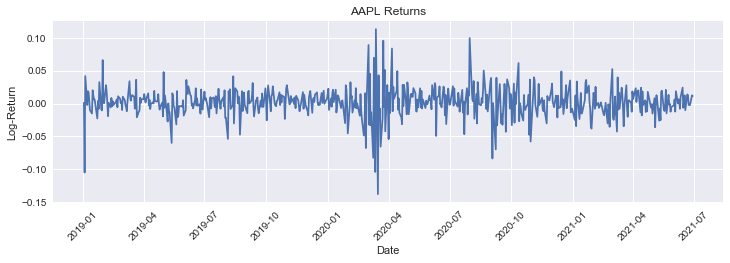

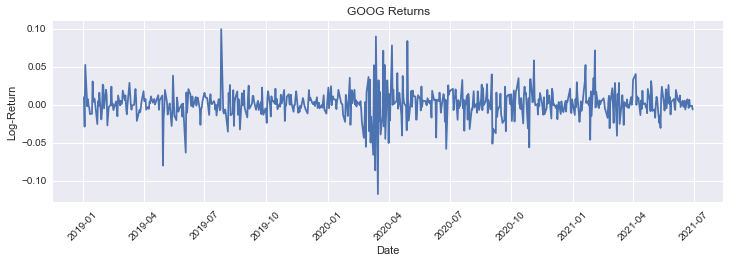

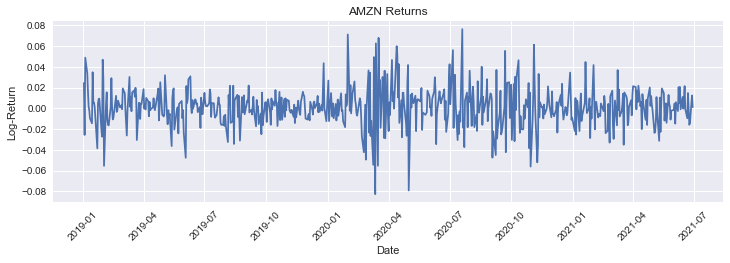

In [9]:
risk_factors_and_positions = risk_factors.RiskFactorsAndPositions(
    ptf_spec_path=config['ptf_spec_path'],
    load_from_csv=config['load_from_csv'],
    risk_factors_path=config['risk_factors_path'],
    start=config['start'],
    end=config['end'],
    nan_threshold=config['nan_threshold'],
    report=report
)

rf, rf_rets, position_configurations, tickers = risk_factors_and_positions.run()

## 3.2 Volatilities and Correlations Estimation

Risk Factor Volatilites:

        sample  ledoit_wolf      ewma
FB    0.023830     0.023753  0.017161
AAPL  0.023746     0.023672  0.011659
GOOG  0.020332     0.020362  0.009546
AMZN  0.019630     0.019683  0.012276


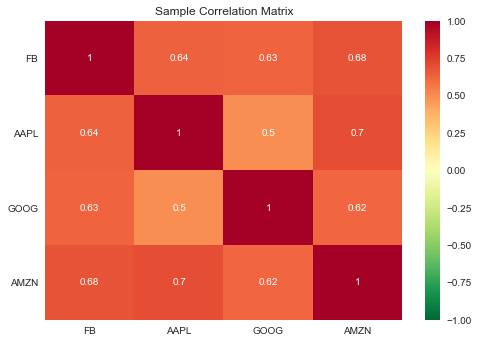

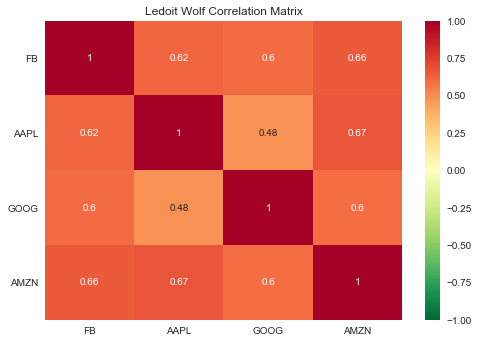

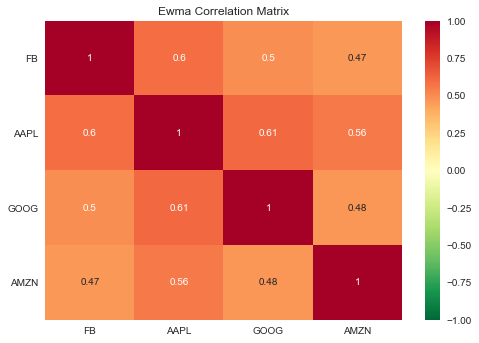

In [10]:
rf_estimator = risk_factors.CorrelationAndVolatilityEstimators(
    rf_estim_method=config['rf_estim_method'],
    vol_period=config['vol_period'],
    corr_period=config['corr_period'],
    rf_rets=rf_rets.copy(),
    report=report,
    lmbda=config['lmbda']
)

rf_hist_vols, rf_corr_mat = rf_estimator.run()

# 4 Portfolio

In [11]:
report.chapter('Portfolio')

In [12]:
ptf_def = portfolio.PortfolioDefinition(
    position_configurations=position_configurations,
    rf_levels=rf.iloc[:1, :],
    report=report,
    amer_opt_params=amer_opt_params.copy()
)

positions_df, ptf_market_value, position_names = ptf_def.run()

positions_df

Portfolio Market Value ($):	64567.0


0          1  \
position                   product_type             Equity     Equity   
                           asset                 AAPL Long  AMZN Long   
                           price_ticker               AAPL       AMZN   
                           rate_ticker                 NaN        NaN   
                           yield_ticker                NaN        NaN   
                           vol_ticker                  NaN        NaN   
                           price                    136.33    3448.14   
                           securities_contracts         10         10   
                           notional_value              NaN        NaN   
                           direction                  Long       Long   
                           market_value             1363.3    34481.4   
price_inputs        option option_type                 NaN        NaN   
                           callput                     NaN        NaN   
                           settlement                  NaN        NaN   
                           maturity                    NaN        NaN   
                           r                           NaN        NaN   
                           d                           NaN        NaN   
                           K                           NaN        NaN   
                           v                           NaN        NaN   
                           S                           NaN        NaN   
                    bond   settlement                  NaN        NaN   
                           maturity                    NaN        NaN   
                           coup                        NaN        NaN   
                           ytm                         NaN        NaN   
                           par                         NaN        NaN   
                           freq                        NaN        NaN   
                    future S                           NaN        NaN   
                           delivery_price              NaN        NaN   
                           r                           NaN        NaN   
                           d                           NaN        NaN   
                           settlement                  NaN        NaN   
                           maturity                    NaN        NaN   
price_sensitivities        risk_characteristic      Linear     Linear   
                    sec    delta                         1          1   
                           gamma                       NaN        NaN   
                           vega                        NaN        NaN   
                           pv01                        NaN        NaN   
                           cvex01                      NaN        NaN   
                    pos    delta                        10         10   
                           gamma                       NaN        NaN   
                           vega                        NaN        NaN   
                           pv01                        NaN        NaN   
                           cvex01                      NaN        NaN   

                                                       2          3  
position                   product_type           Equity     Equity  
                           asset                 FB Long  GOOG Long  
                           price_ticker               FB       GOOG  
                           rate_ticker               NaN        NaN  
                           yield_ticker              NaN        NaN  
                           vol_ticker                NaN        NaN  
                           price                  351.89    2520.37  
                           securities_contracts       10         10  
                           notional_value            NaN        NaN  
                           direction                Long       Long  
                           market_value           3518.9    25203.7  
pric

# 5 Value At Risk Models

## 5.1 Parametric VaR



Risk Factor Information:

                           FB       AAPL       GOOG      AMZN
Current Level          351.89     136.33    2520.37   3448.14
Volatility (%)      0.0237532  0.0236717  0.0203622  0.019683
Volatility (units)    8.35853    3.22717    51.3202   67.8697


Risk Factor Sensitivities:

             FB  AAPL  GOOG  AMZN
AAPL Long   0.0  10.0   0.0   0.0
AMZN Long   0.0   0.0   0.0  10.0
FB Long    10.0   0.0   0.0   0.0
GOOG Long   0.0   0.0  10.0   0.0
Portfolio  10.0  10.0  10.0  10.0


Dollar Volatilities:

                  FB       AAPL       GOOG        AMZN
AAPL Long   0.000000  32.271665    0.00000    0.000000
AMZN Long   0.000000   0.000000    0.00000  678.697082
FB Long    83.585276   0.000000    0.00000    0.000000
GOOG Long   0.000000   0.000000  513.20157    0.000000
Net        83.585276  32.271665  513.20157  678.697082


Asset Covariance Matrix:

              AAPL Long      AMZN Long       FB Long      GOOG Long
AAPL Long   1041.460376   14729.226068  

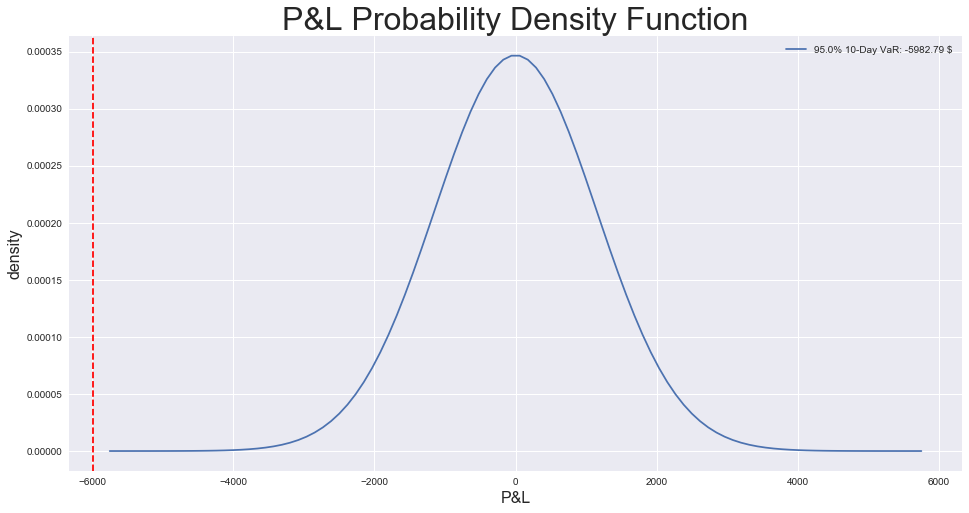

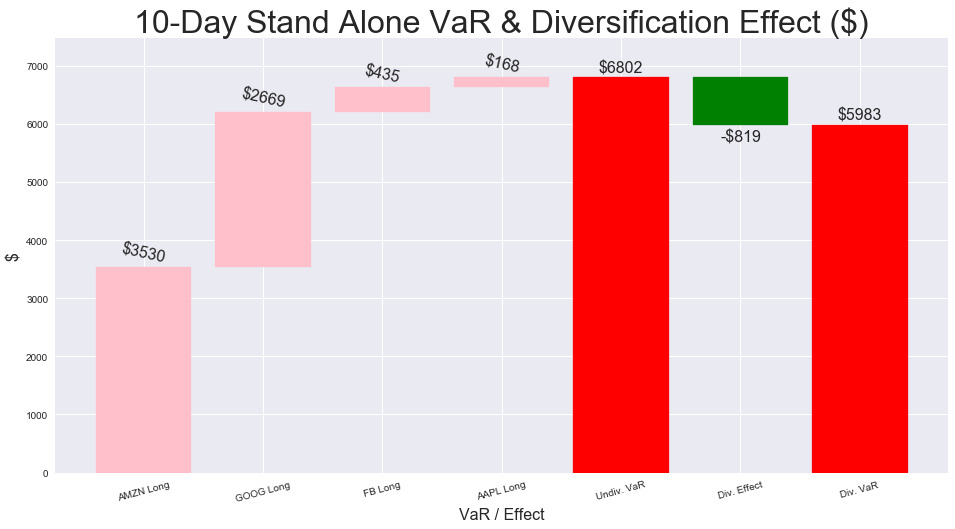

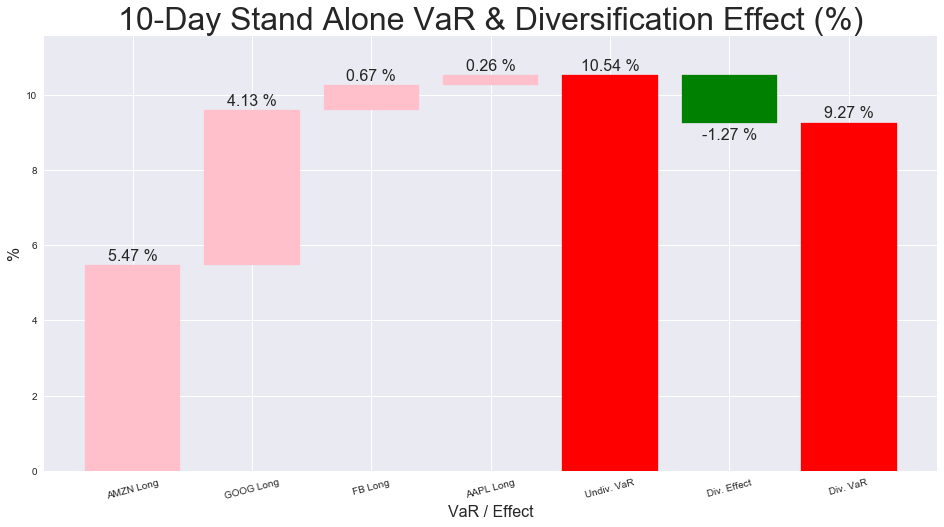

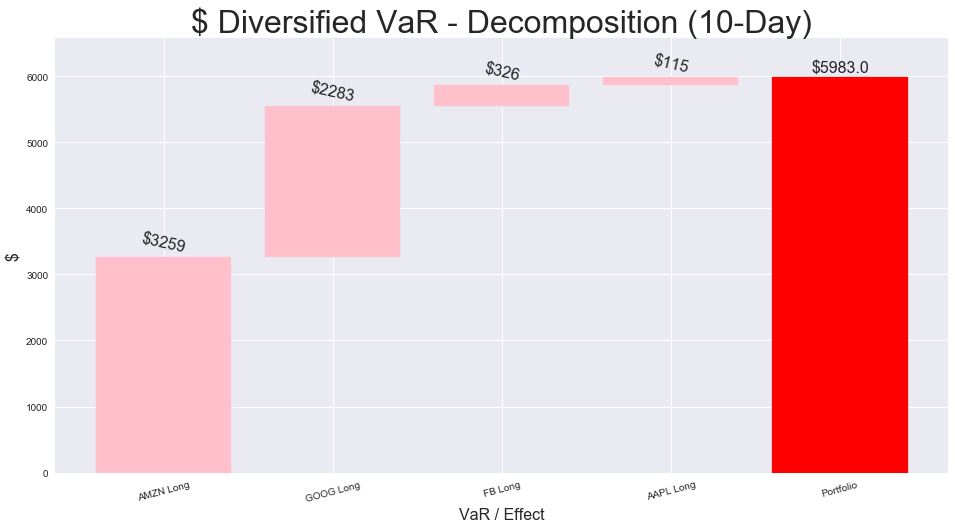

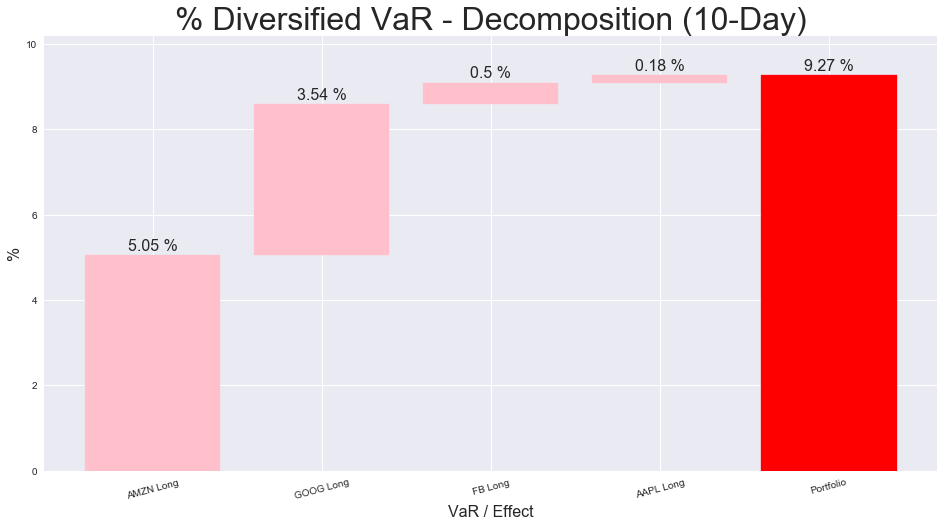

In [13]:
parametric_value_at_risk = var_models.ParametricValueAtRisk(
    report=report,
    VaR_horizon=config['VaR_horizon'],
    confidence=config['confidence'],
    rf=rf,
    rf_hist_vols=rf_hist_vols,
    rf_corr_mat=rf_corr_mat,
    tickers=tickers,
    position_names=position_names,
    positions_df=positions_df
)

parametric_value_at_risk.run()

## 5.2 Monte Carlo VaR



Shifted Levels:

        FB     AAPL     GOOG     AMZN
1  347.953  123.682  2353.76  3264.87
2  342.178  133.444  2395.28  3468.03
3  325.597  133.645  2537.81  3349.56
4  367.394  150.862  2415.74  3453.06
5  340.001  132.202  2483.87  3565.41


Full Revaluation P&L:

    AAPL Long    AMZN Long     FB Long    GOOG Long
1 -126.481417 -1832.692152  -39.369559 -1666.125836
2  -28.856411   198.853746  -97.118529 -1250.863079
3  -26.849364  -985.837428 -262.926099   174.413721
4  145.323497    49.192850  155.037288 -1046.301156
5  -41.277893  1172.716168 -118.894812  -365.028294


Portfolio Revaluation P&L:

       P&L ($)   P&L (%)
1 -3664.668964 -0.056757
2 -1177.984274 -0.018244
3 -1101.199170 -0.017055
4  -696.747521 -0.010791
5   647.515168  0.010029


Value at Risk:

            AAPL Long AMZN Long   FB Long GOOG Long    Portfolio
VaR          -158.215  -3366.64  -403.424  -2587.75 -5761.276632
Correlation  0.692203  0.922447  0.746635  0.856613          NaN


Sub-Portfolio P&Ls:



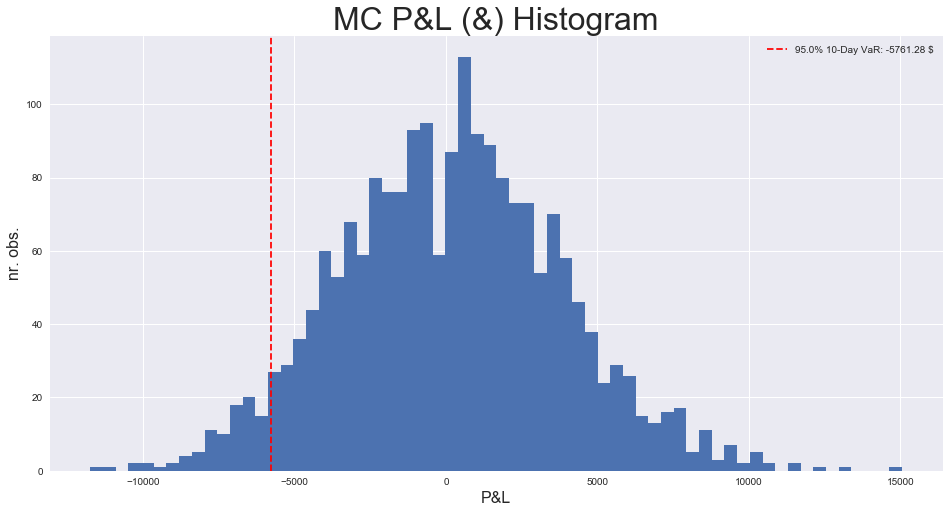

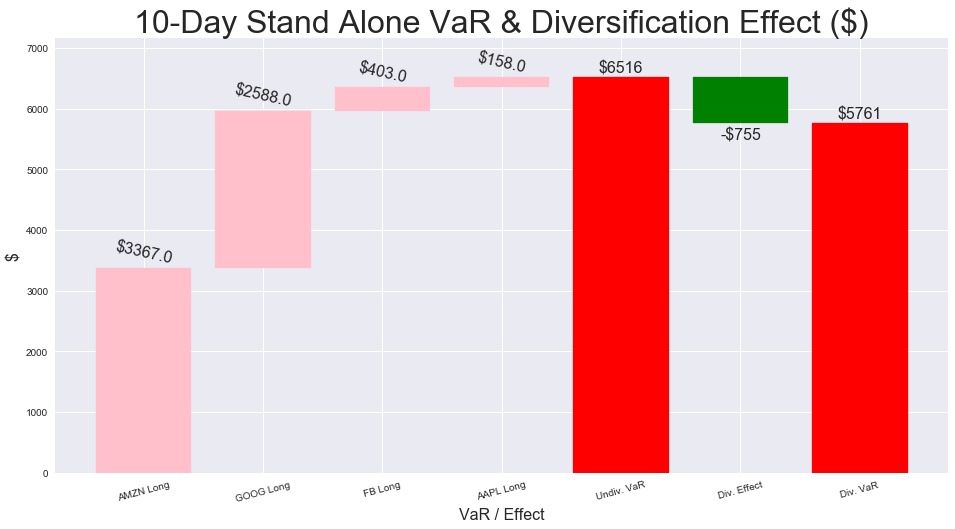

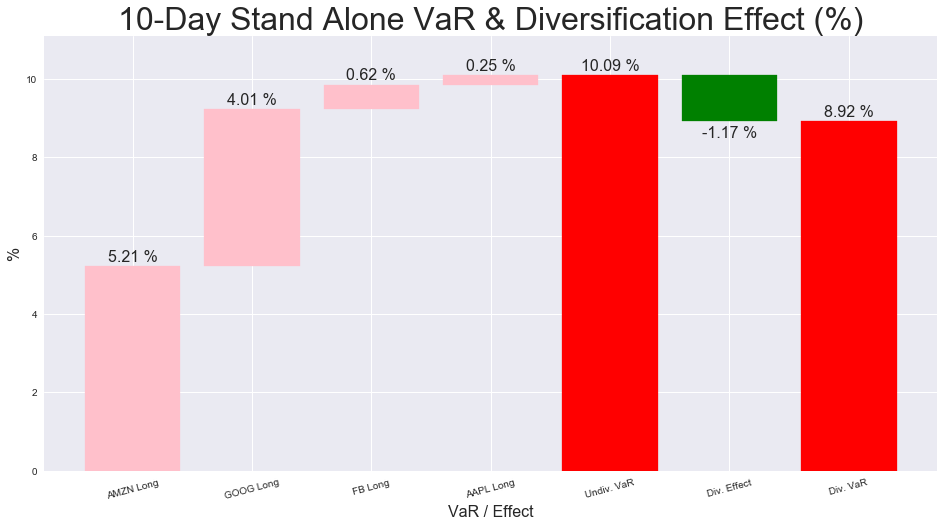

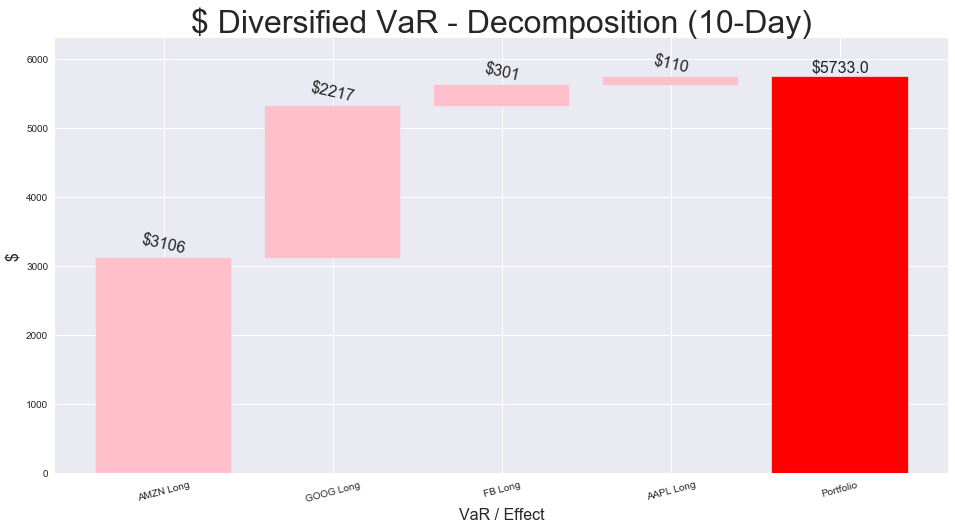

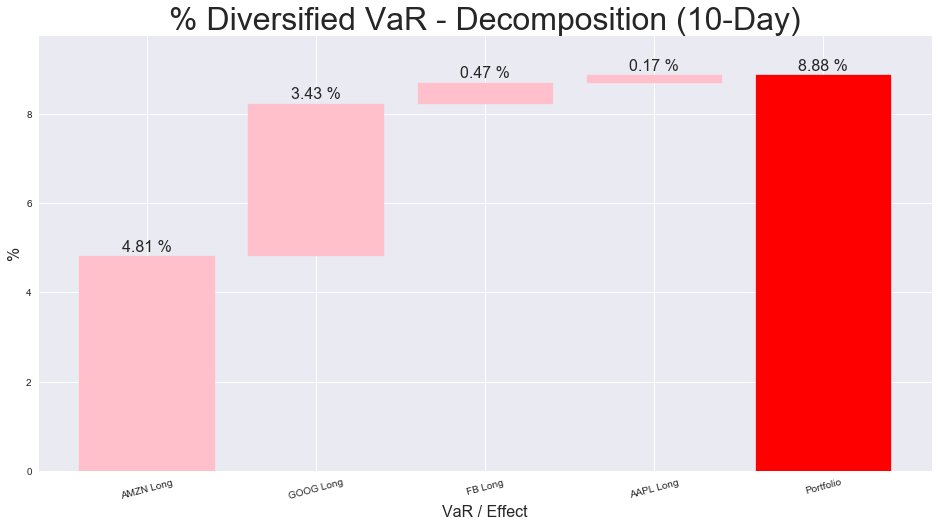

In [14]:
monte_carlo_value_at_risk = var_models.MonteCarloValueAtRisk(
    report=report,
    VaR_horizon=config['VaR_horizon'],
    confidence=config['confidence'],
    rf_hist_vols=rf_hist_vols,
    rf_corr_mat=rf_corr_mat,
    position_names=position_names,
    n_mc_scenarios=config['n_mc_scenarios'],
    rf=rf,
    positions_df=positions_df,
    ptf_market_value=ptf_market_value,
    amer_opt_params=amer_opt_params
)

monte_carlo_value_at_risk.run()

## 5.3 Historical Simulation VaR



Shifted Levels:

           FB        AAPL         GOOG         AMZN
0  348.179556  137.897830  2504.451522  3452.395137
1  366.599794  138.040398  2516.887097  3491.152111
2  350.034079  136.023432  2514.687106  3400.532756
3  354.565941  136.034304  2536.722546  3394.269791
4  353.509186  136.045092  2509.693222  3446.546498


Full Revaluation P&L:

   AAPL Long   AMZN Long     FB Long   GOOG Long
0  15.678285   42.552448  -37.104586 -159.185949
1  17.103963  430.122188  147.097796  -34.830206
2  -3.065693 -476.071364  -18.559359  -56.830111
3  -2.956977 -538.701019   26.759267  163.524284
4  -2.849100  -15.933945   16.191711 -106.768953


Portfolio Revaluation P&L:

          P&L
0 -138.059802
1  559.493740
2 -554.526528
3 -351.374446
4 -109.360287


Bootstrapped P&L:

  AAPL Long AMZN Long  FB Long GOOG Long Portfolio
0   78.6877   2839.72  87.7338   1940.96    4947.1
1   52.6144  -1005.88 -132.727  -518.991  -1604.98
2   14.1601   5250.53 -162.166   994.733   6097.26
3   51.6869

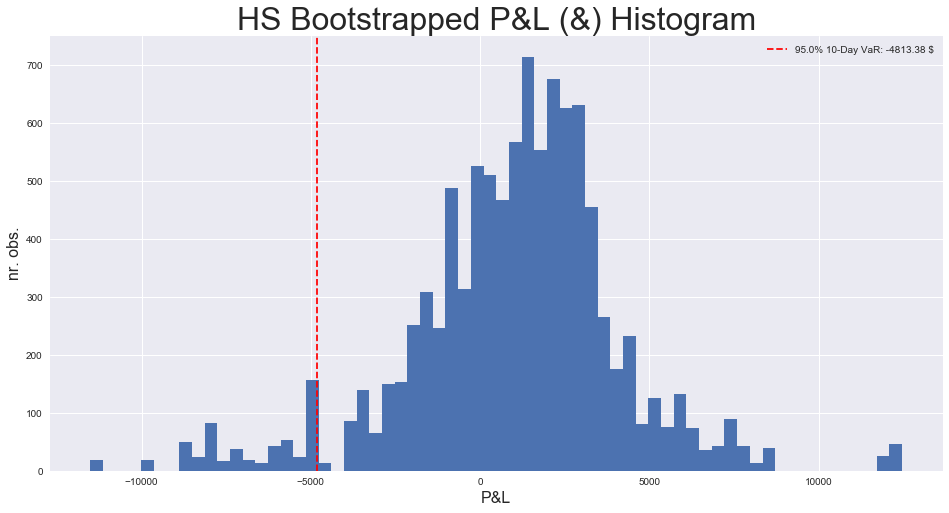

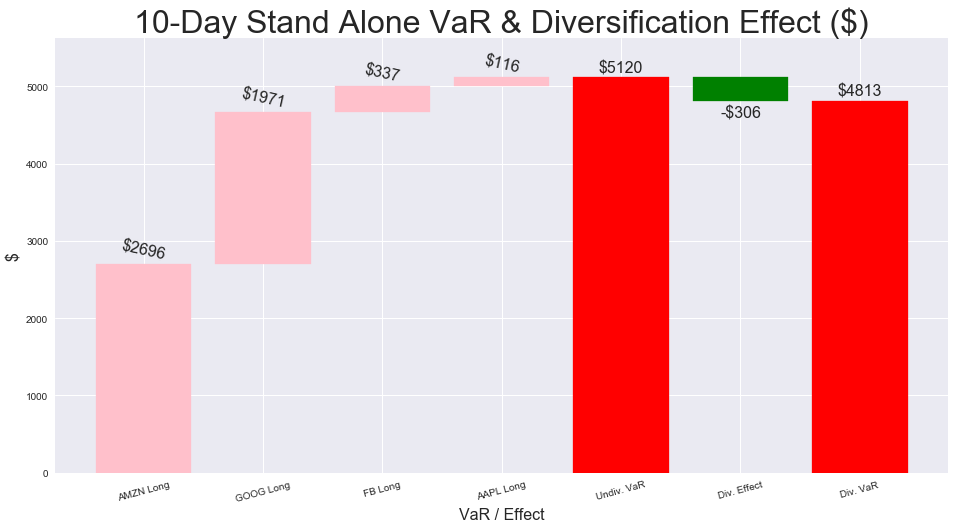

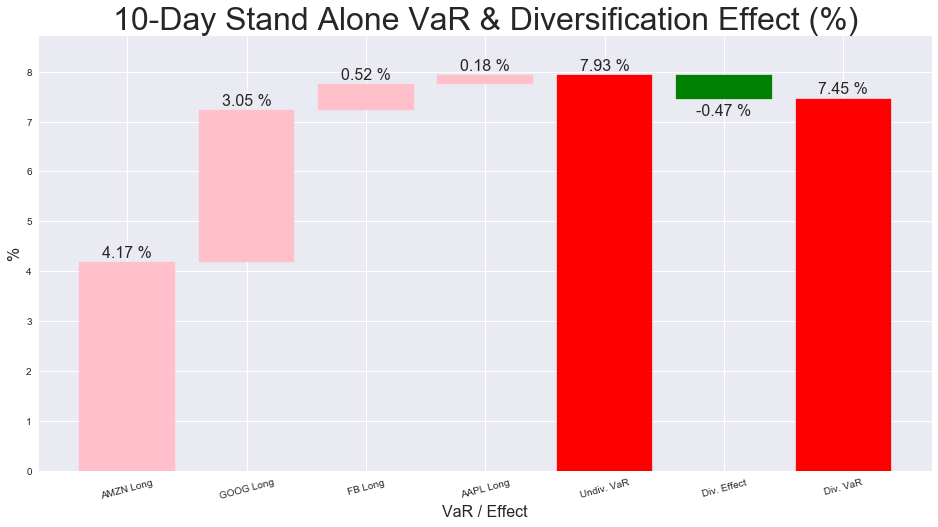

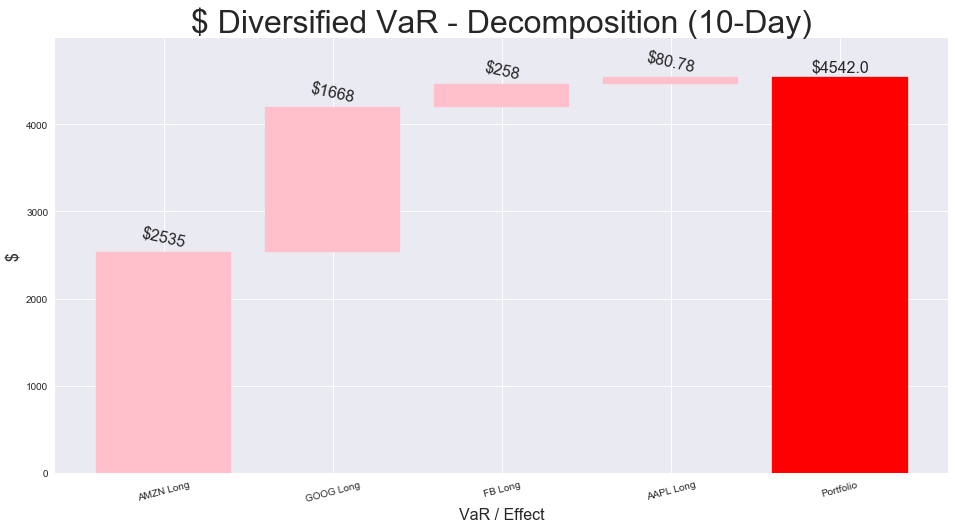

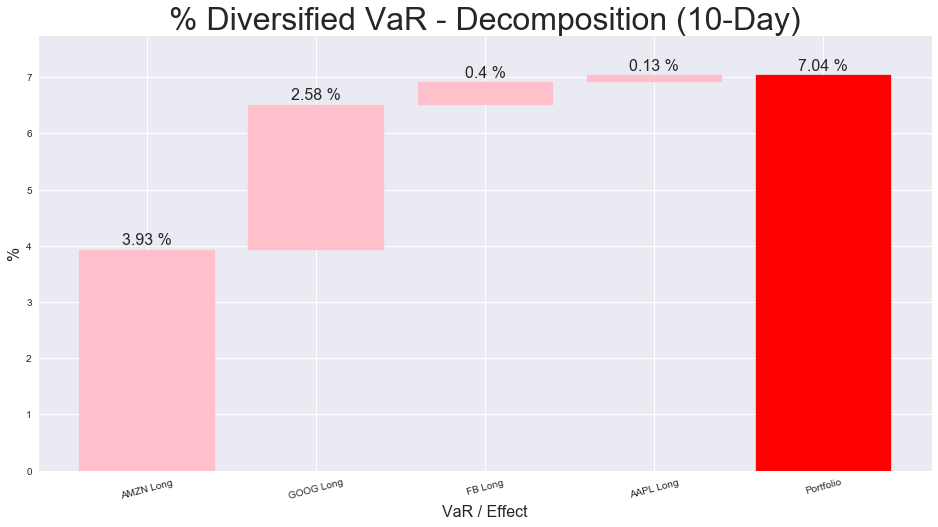

In [15]:
historical_simulation_value_at_risk = var_models.HistoricalSimulationValueAtRisk(
    report=report,
    VaR_horizon=config['VaR_horizon'],
    confidence=config['confidence'],
    position_names=position_names,
    rf=rf,
    rf_rets=rf_rets,
    hs_period=config['hs_period'],
    n_bootstrap=config['n_bootstrap'],
    positions_df=positions_df,
    ptf_market_value=ptf_market_value,
    amer_opt_params=amer_opt_params,
    corr_period=config['corr_period']
)

historical_simulation_value_at_risk.run()

## 5.4 VaR Models Summary

In [16]:
models_summary = var_models.ModelsSummary(
    pvar_model=parametric_value_at_risk,
    mcvar_model=monte_carlo_value_at_risk,
    hsvar_model=historical_simulation_value_at_risk,
    position_names=position_names,
    report=report
)

models_summary.run()



Component VaR:

      AAPL Long AMZN Long  FB Long GOOG Long      Sum
PVaR   -114.801  -3258.87  -325.65  -2283.47 -5982.79
MCVaR  -109.517  -3105.55  -301.21   -2216.7 -5732.97
HSVaR  -80.7769  -2535.35 -257.921   -1668.3 -4542.34


Incremental VaR:

      AAPL Long AMZN Long  FB Long GOOG Long
PVaR   -113.523  -2939.43 -318.321  -2033.56
MCVaR  -161.344  -2826.99 -296.174  -1907.43
HSVaR  -101.067  -2480.57 -211.167   -1595.5


Diversification:

      Undiv. VaR Div. VaR Div. Effect ($) Div. Effect (%) Div. Ratio
PVaR    -6802.27 -5982.79        -819.477        0.120471   0.879529
MCVaR   -6516.03 -5761.28        -754.751         0.11583    0.88417
HSVaR    -5119.8 -4813.38        -306.424       0.0598508   0.940149


# 6 Backtesting Weighting Schemes



Asset Valuations:

                  AAPL          AMZN           FB          GOOG
Date                                                           
2018-12-31  383.959198  15019.699707  1310.899963  10356.099854
2019-01-02  384.397354  15391.300049  1356.799927  10458.499756
2019-01-03  346.108513  15002.800293  1317.400055  10160.599976
2019-01-04  360.883636  15753.900146  1379.499969  10707.099609
2019-01-07  360.080414  16295.100098  1380.500031  10683.900146


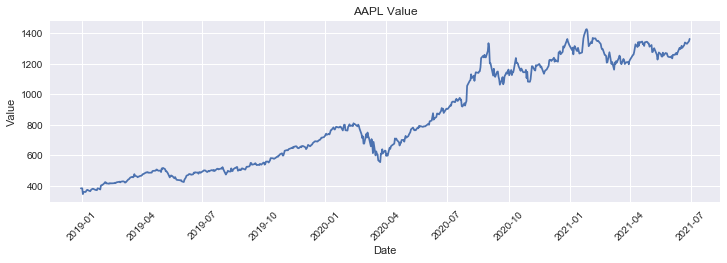

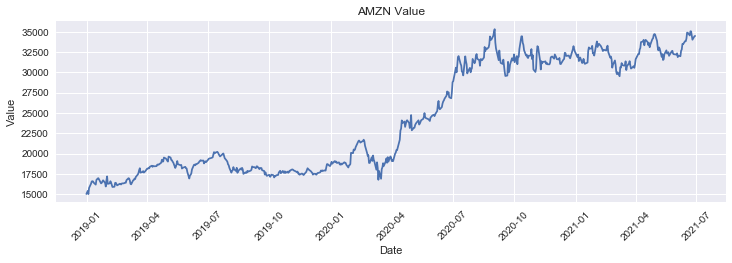

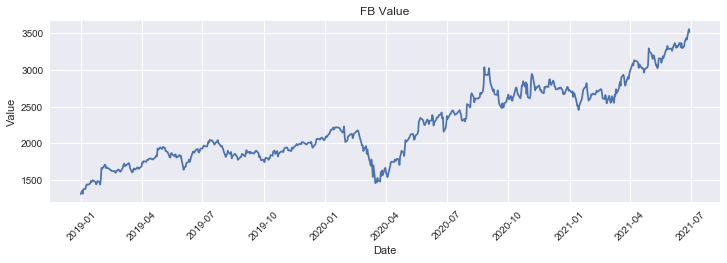

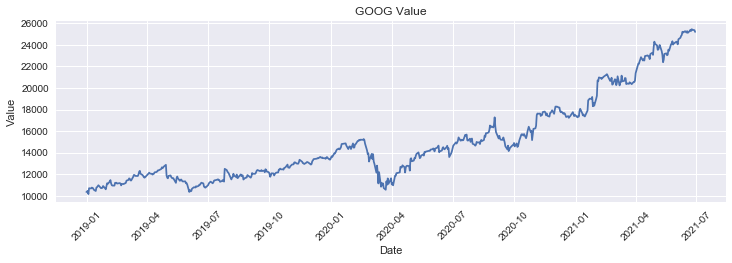



Portfolio Valuation:

                   Value
Date                    
2018-12-31  27070.658722
2019-01-02  27590.997086
2019-01-03  26826.908836
2019-01-04  28201.383362
2019-01-07  28719.580688


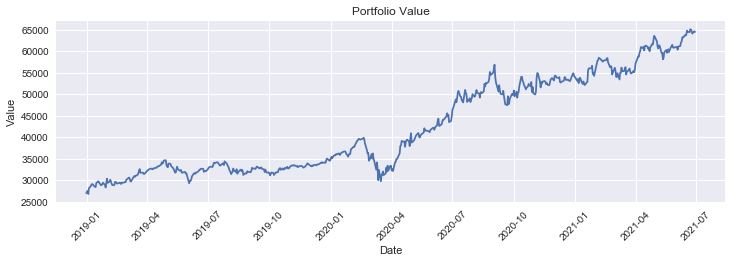



Asset Returns:

                AAPL      AMZN        FB      GOOG
Date                                              
2019-01-02  0.001141  0.024741  0.035014  0.009888
2019-01-03 -0.099607 -0.025242 -0.029039 -0.028484
2019-01-04  0.042689  0.050064  0.047138  0.053786
2019-01-07 -0.002226  0.034353  0.000725 -0.002167
2019-01-08  0.019063  0.016612  0.032452  0.007385


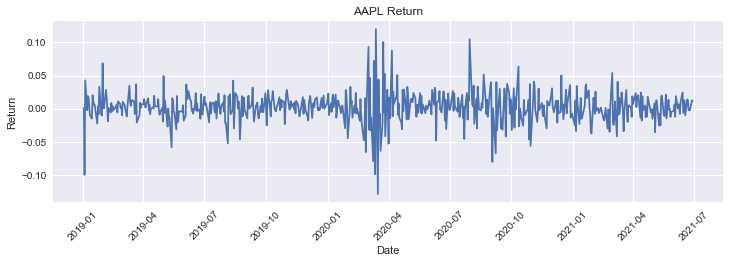

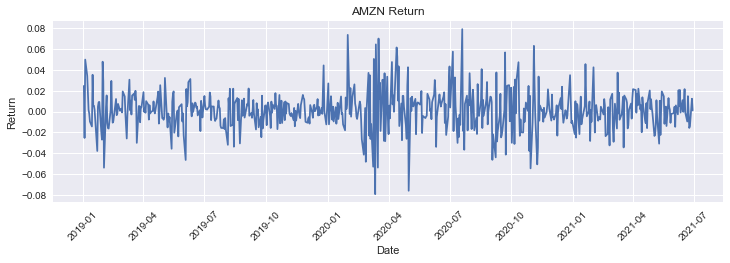

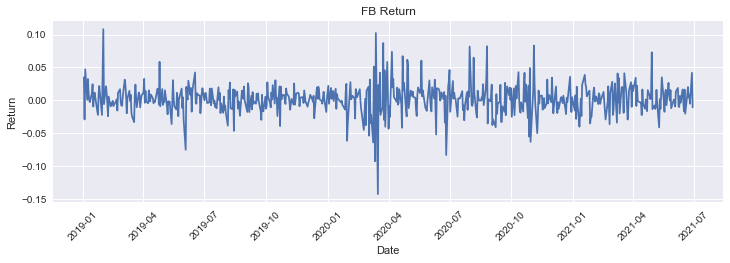

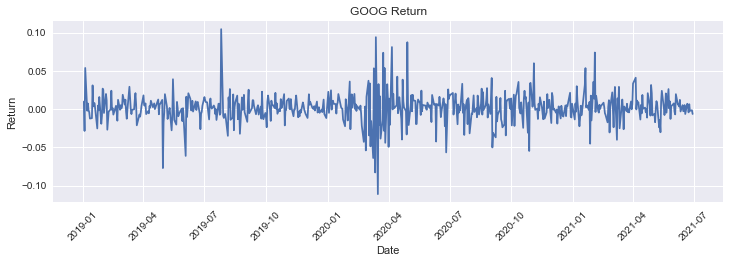



Portfolio Returns:

              Return
Date                
2019-01-02  0.019221
2019-01-03 -0.027693
2019-01-04  0.051235
2019-01-07  0.018375
2019-01-08  0.013972


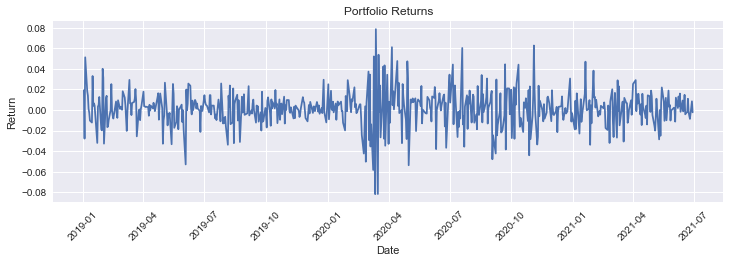

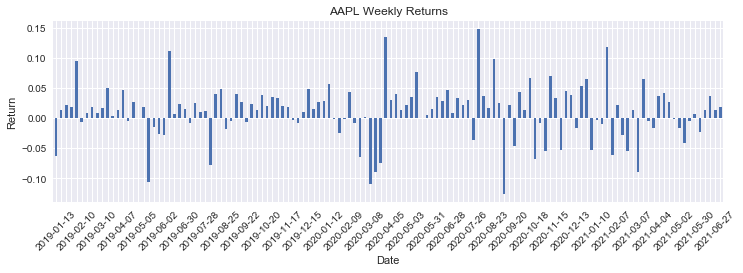

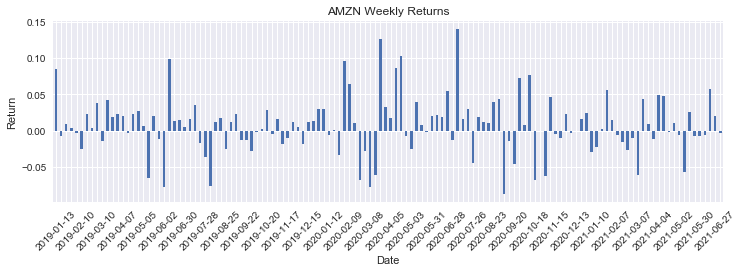

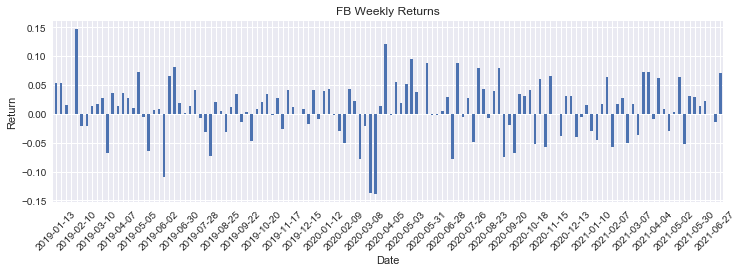

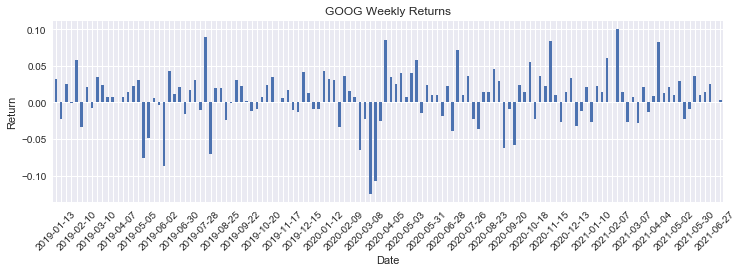

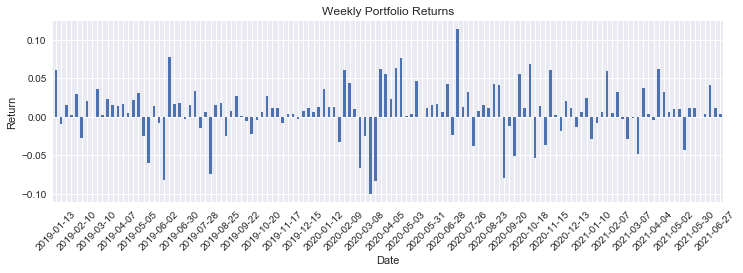



Expected Annualized Returns:

      AAPL      AMZN        FB      GOOG
0  0.65248  0.393655  0.490653  0.430895


Expected Annualized Volatilities:

       AAPL    AMZN        FB      GOOG
0  0.325137  0.2856  0.340738  0.259505


Correlation Matrix:

          AAPL      AMZN        FB      GOOG
AAPL  1.000000  0.551215  0.646774  0.615291
AMZN  0.551215  1.000000  0.569265  0.562839
FB    0.646774  0.569265  1.000000  0.671117
GOOG  0.615291  0.562839  0.671117  1.000000


Covariance Matrix:

          AAPL      AMZN        FB      GOOG
AAPL  0.002000  0.000910  0.001274  0.000923
AMZN  0.000910  0.001571  0.000985  0.000742
FB    0.001274  0.000985  0.002185  0.001055
GOOG  0.000923  0.000742  0.001055  0.001318


Annualized Covariance Matrix:

          AAPL      AMZN        FB      GOOG
AAPL  0.104020  0.047330  0.066257  0.048005
AMZN  0.047330  0.081692  0.051226  0.038573
FB    0.066257  0.051226  0.113626  0.054873
GOOG  0.048005  0.038573  0.054873  0.068538


Market Capital

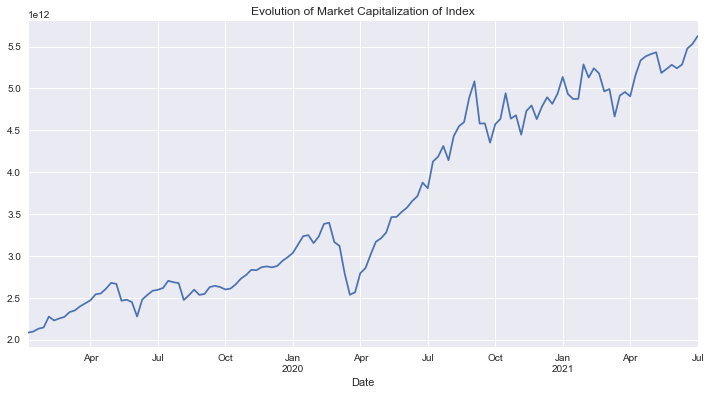



Capitalization Weights:

                AAPL      AMZN        FB      GOOG
Date                                              
2019-01-13  0.285044  0.393551  0.157595  0.163811
2019-01-20  0.287376  0.388342  0.165023  0.159259
2019-01-27  0.288980  0.385638  0.164807  0.160575
2019-02-03  0.292637  0.384365  0.163578  0.159420
2019-02-10  0.302360  0.361452  0.177040  0.159149


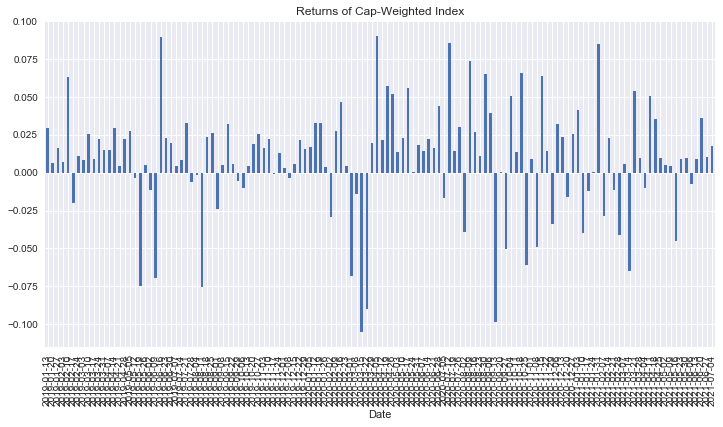

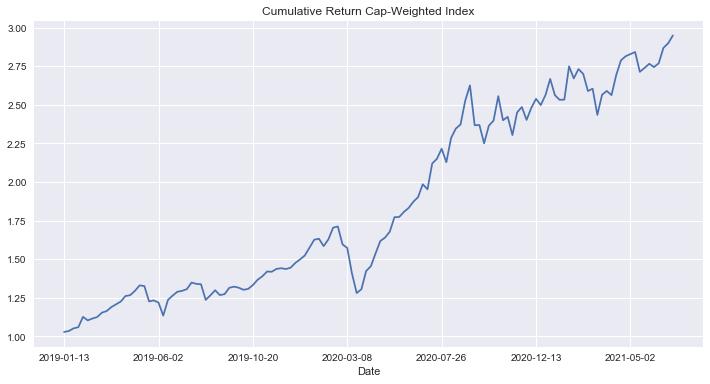



Weights of Capweight Scheme:

               AAPL      AMZN        FB      GOOG
2020-01-05  0.39202  0.306685  0.160441  0.140855
Portfolio Return for Capweight Scheme: 0.5159
Portfolio Volatility for Capweight Scheme: 0.2526


Weights of Equal Weighted Scheme:

   AAPL  AMZN    FB  GOOG
0  0.25  0.25  0.25  0.25
Portfolio Return for Equal Weighted Scheme: 0.4919
Portfolio Volatility for Equal Weighted Scheme: 0.2475


Weights of Equal-Weighted Benchmark:

            AAPL  AMZN    FB  GOOG
Date                              
2019-01-13  0.25  0.25  0.25  0.25
2019-01-20  0.25  0.25  0.25  0.25
2019-01-27  0.25  0.25  0.25  0.25
2019-02-03  0.25  0.25  0.25  0.25
2019-02-10  0.25  0.25  0.25  0.25


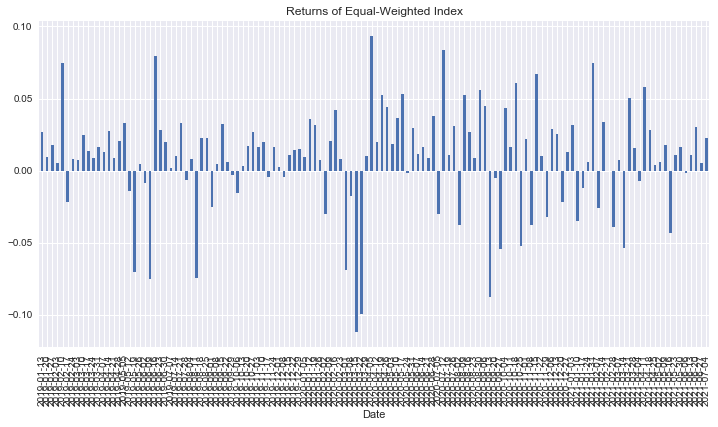

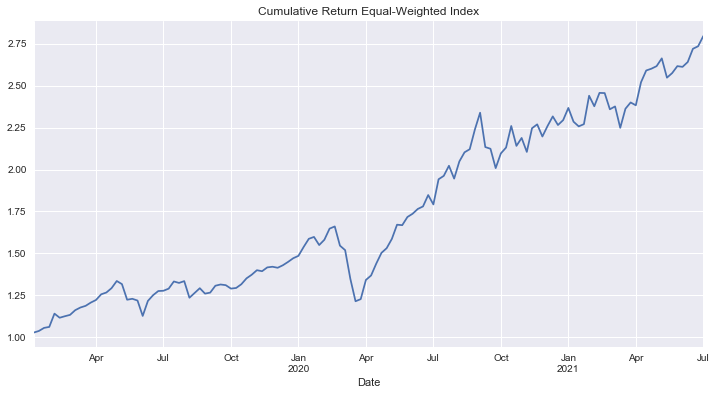

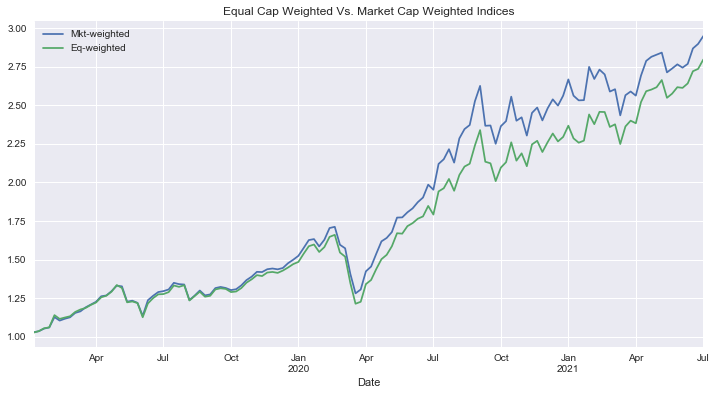

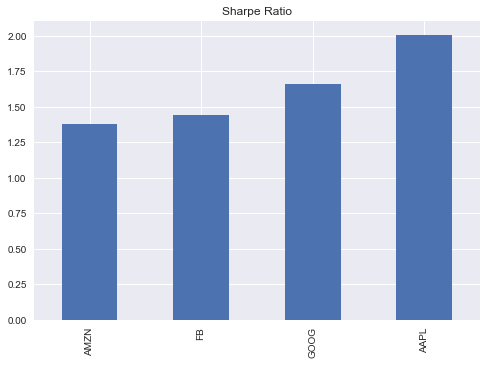

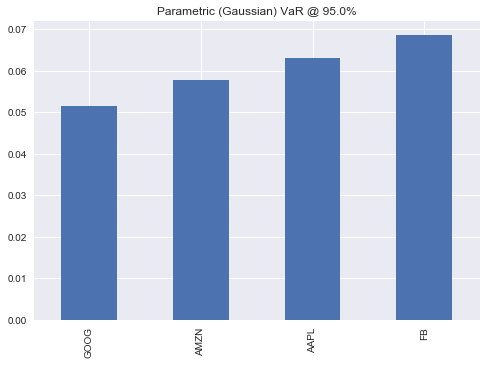

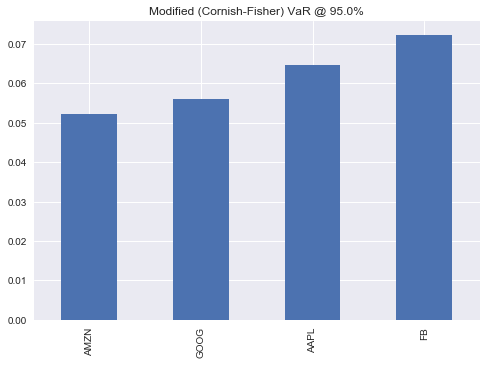

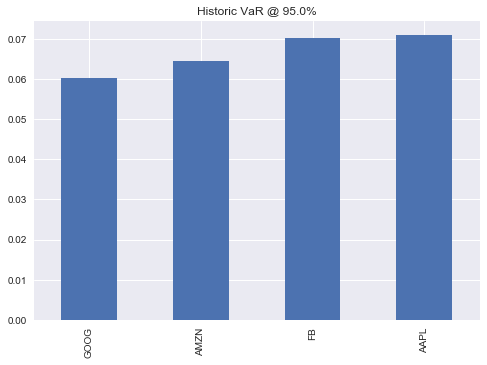

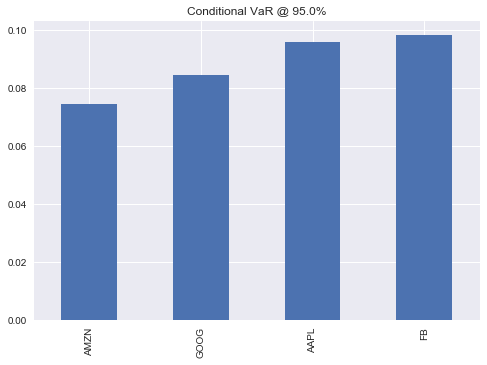

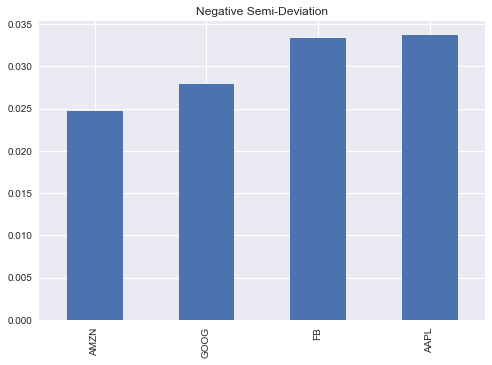

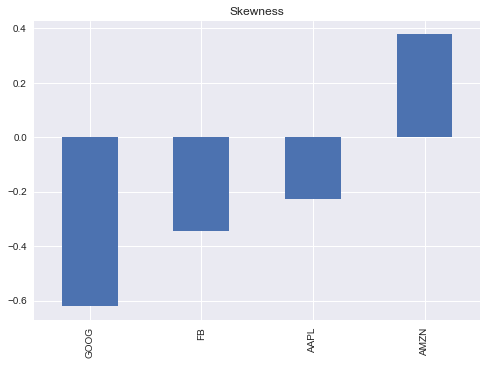

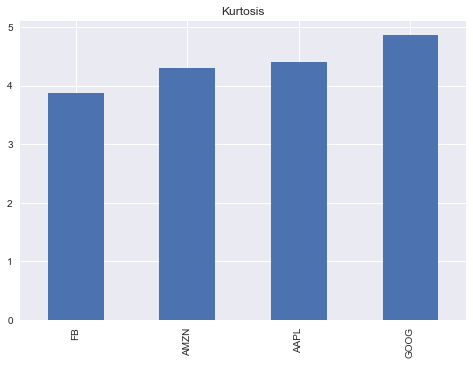

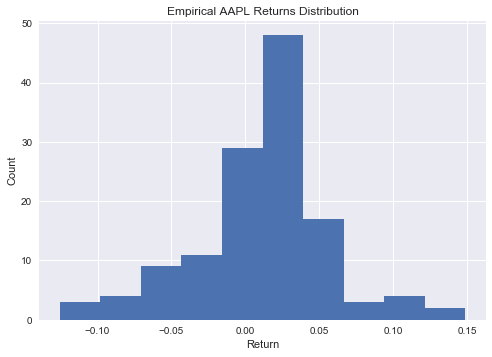

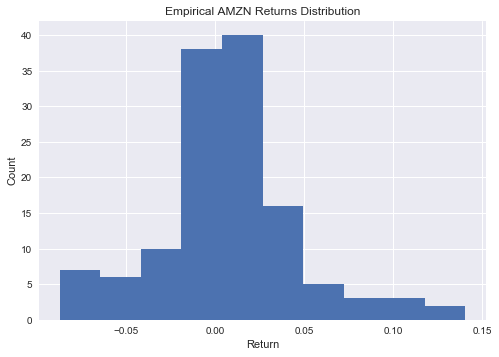

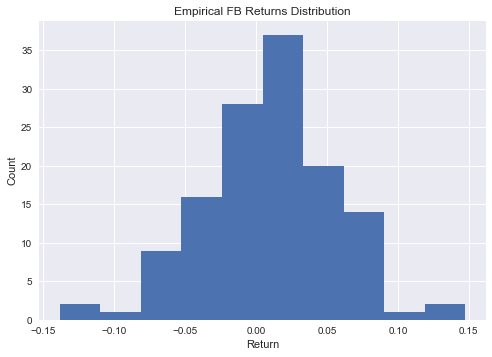

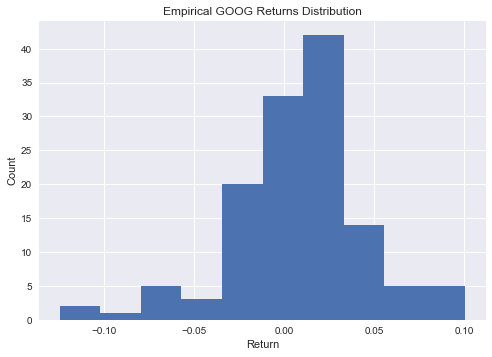



Normality Test Results:

    AAPL   AMZN    FB   GOOG
0  False  False  True  False


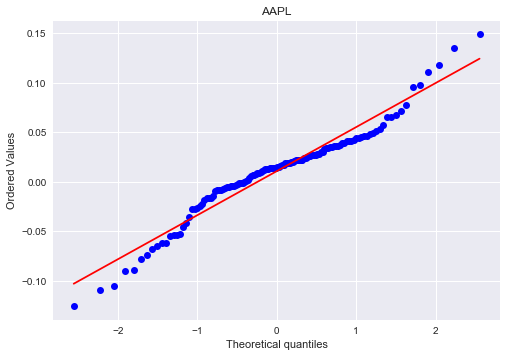

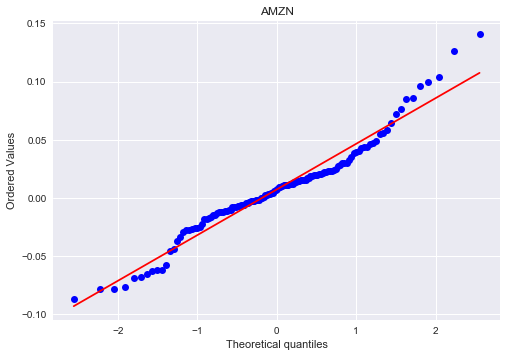

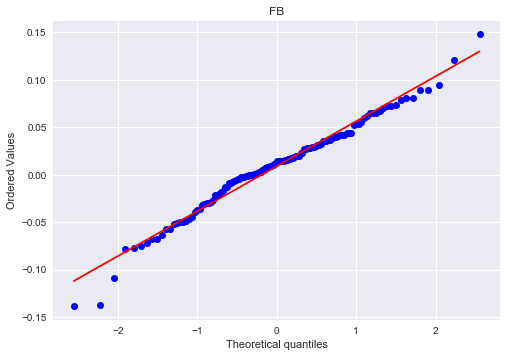

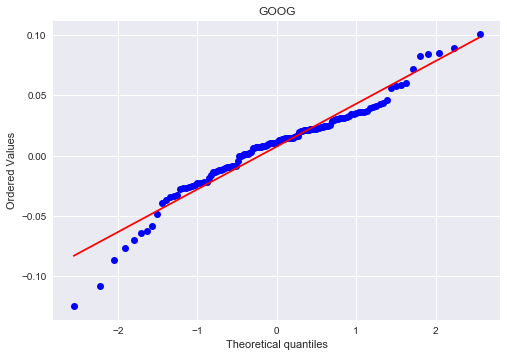

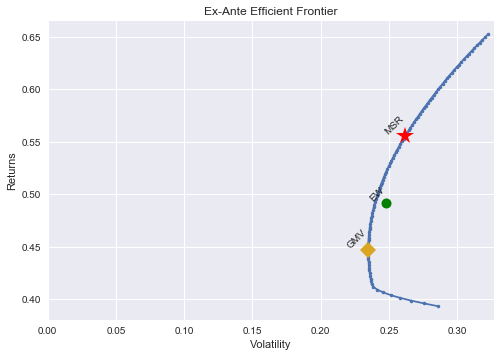



Weights of Maximum Sharpe Ratio Scheme:

       AAPL      AMZN            FB      GOOG
0  0.582104  0.113767  2.168404e-18  0.304129
Portfolio Return for Maximum Sharpe Ratio Scheme: 0.5556
Portfolio Volatility for Maximum Sharpe Ratio Scheme: 0.2619


Weights of Global Minimum Variance Scheme:

       AAPL      AMZN        FB      GOOG
0  0.131225  0.356908  0.001136  0.510731
Portfolio Return for Global Minimum Variance Scheme: 0.4467
Portfolio Volatility for Global Minimum Variance Scheme: 0.2348


Weights of Equal Risk Contribution Scheme:

       AAPL      AMZN       FB      GOOG
0  0.229681  0.271722  0.21427  0.284327
Portfolio Return for Equal Risk Contribution Scheme: 0.4845
Portfolio Volatility for Equal Risk Contribution Scheme: 0.2441


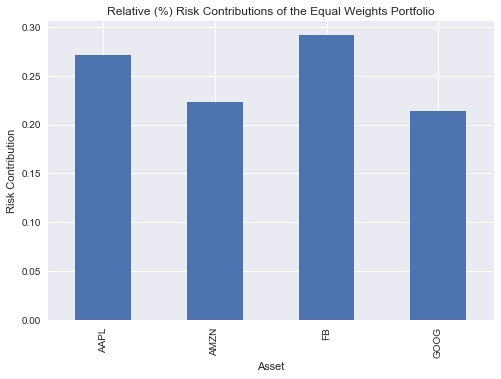

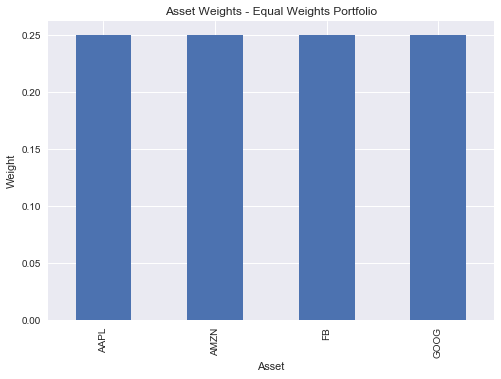

Equal Weights Portfolio volatility: 0.0343


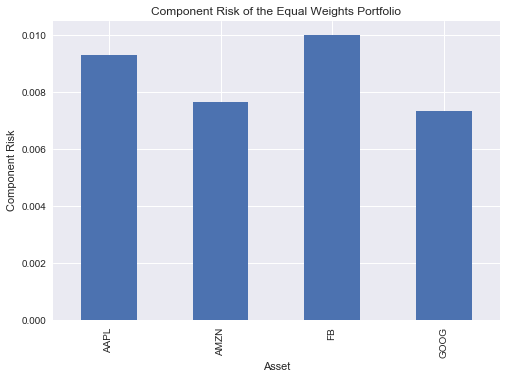

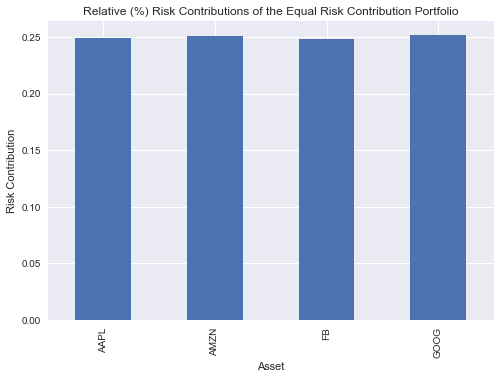

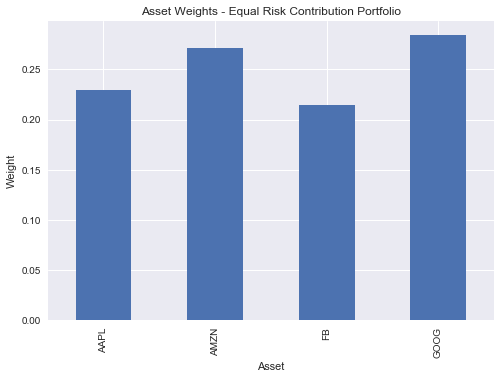

Equal Risk Contribution Portfolio volatility: 0.0339


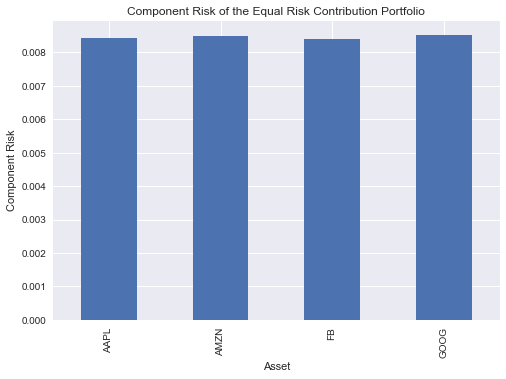



Backtesting Returns:

            Historical        EW        CW       MSR       GMV       ERC
Date                                                                    
2020-01-12    0.035790  0.035562  0.032982  0.031205  0.035081  0.035427
2020-01-19    0.011909  0.031809  0.032146  0.056040  0.024644  0.030415
2020-01-26    0.012092  0.007102  0.003737 -0.001268  0.010305  0.007717
2020-02-02   -0.033461 -0.030352 -0.029246 -0.024518 -0.031527 -0.030566
2020-02-09    0.064831  0.020459  0.024946 -0.001620  0.046026  0.025471


Cumulative Returns:

            Historical        EW        CW       MSR       GMV       ERC
Date                                                                    
2020-01-12    1.035790  1.035562  1.032982  1.031205  1.035081  1.035427
2020-01-19    1.048125  1.068501  1.066188  1.088994  1.060589  1.066920
2020-01-26    1.060799  1.076089  1.070173  1.087613  1.071518  1.075153
2020-02-02    1.025303  1.043428  1.038874  1.060947  1.037737  1.042291
2020

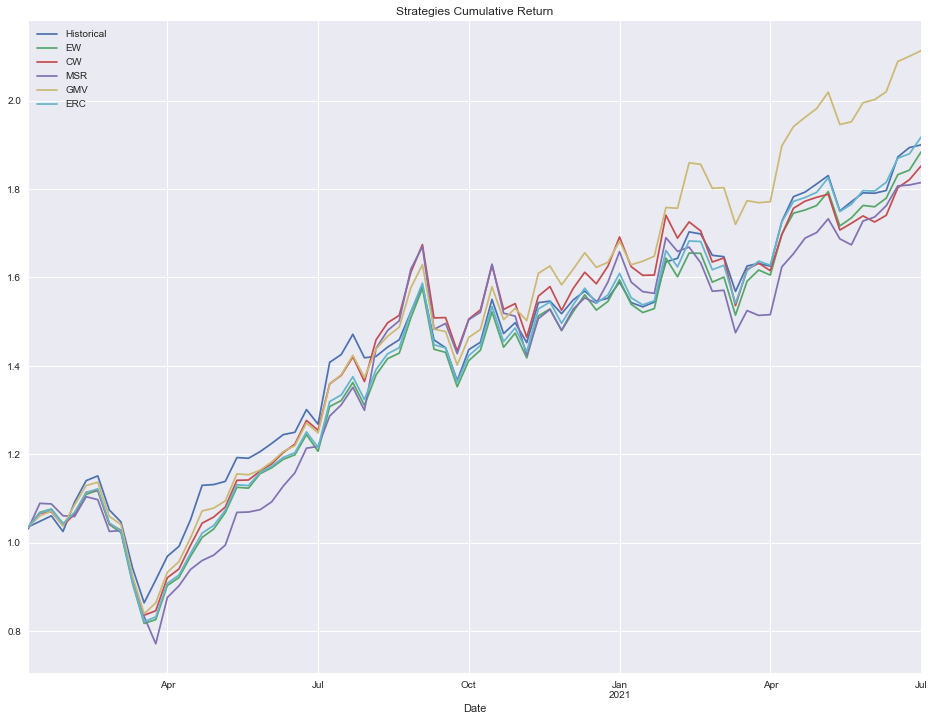



Performance Summary (Annualized):

                       Historical        EW        CW       MSR       GMV       ERC
Return                   0.533926  0.525254  0.508077  0.487753  0.646551  0.543317
Volatility               0.272482  0.286449  0.295006  0.321108  0.276864  0.284176
Semi-Deviation           0.196307  0.214693  0.205115  0.235520  0.219755  0.215518
Skewness                -0.357138 -0.730330 -0.617522 -0.281080 -0.721439 -0.737577
Kurtosis                 3.636853  3.784395  3.432393  3.929928  4.069787  3.847181
Gaussian VaR (95.0%)     0.052786  0.055979  0.058092  0.064123  0.052375  0.055248
Modified VaR (95.0%)     0.056025  0.063152  0.064581  0.066762  0.059002  0.062387
Historic VaR (95.0%)     0.053918  0.056537  0.066001  0.068896  0.053691  0.056059
Historic CVaR (95.0%)    0.081979  0.092175  0.090860  0.096266  0.090446  0.091830
Max. Drawdown           -0.249460 -0.268973 -0.253075 -0.301252 -0.261824 -0.267698
Sharpe Ratio             1.959490  1.83

In [17]:
performance_analysis = ex_post_risk.PerformanceAnalysis(
    horizon=config['bt_horizon'],
    estimation_window=config['estimation_window'],
    confidence=config['confidence'],
    riskfree_rate=config['riskfree_rate'],
    jarque_bera_alpha=config['jarque_bera_alpha'],
    cov_estim_method=config['cov_estim_method'],
    rf=rf,
    report=report,
    position_configurations=position_configurations
)

performance_analysis.run()

In [18]:
report.save()